In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# 검증할 데이터 준비
학습할 때 쓴 데이터가 아닌 다른 코인의 데이터를 사용한다. 

In [2]:
df = pd.read_csv('./data/ETC-M.csv', parse_dates=[0], index_col=[0])
df.drop('value', axis = 1, inplace = True)
df.head(3)

open     high      low    close  volume
2017-09-25 22:05:00  11900.0  11900.0  11900.0  11900.0  0.0001
2017-09-25 22:06:00  11900.0  11900.0  11900.0  11900.0  0.0001
2017-09-25 22:07:00  11900.0  11900.0  11900.0  11900.0  0.0001

In [3]:
len(df)

2407653

In [4]:
df['close'][59041]

14300.0

In [5]:
df['close'][-1]

42660.0

## valid 할 데이터로 정규화

In [6]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

seq_length=20

cuda:0 is available


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class OLNNm(nn.Module):
    def __init__(self, seq_length):
        super(OLNNm, self).__init__()
        self.conv1_1 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=2)
        self.conv1_2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=4)
        self.conv1_3 = nn.Conv1d(in_channels=8, out_channels=5, kernel_size=4)
        self.conv1_4 = nn.Conv1d(in_channels=5, out_channels=3, kernel_size=2)
        self.act1 = nn.GELU()
        
        self.conv2_1 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=2)
        self.conv2_2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=4)
        self.conv2_3 = nn.Conv1d(in_channels=8, out_channels=5, kernel_size=4)
        self.conv2_4 = nn.Conv1d(in_channels=5, out_channels=3, kernel_size=2)
        self.act2 = nn.GELU()
        
        self.conv3_1 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=2)
        self.conv3_2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=4)
        self.conv3_3 = nn.Conv1d(in_channels=8, out_channels=5, kernel_size=4)
        self.conv3_4 = nn.Conv1d(in_channels=5, out_channels=3, kernel_size=2)
        self.act3 = nn.GELU()
        
        self.conv4_1 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=2)
        self.conv4_2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=4)
        self.conv4_3 = nn.Conv1d(in_channels=8, out_channels=5, kernel_size=4)
        self.conv4_4 = nn.Conv1d(in_channels=5, out_channels=3, kernel_size=2)
        self.act4 = nn.GELU()
        
        self.lstm1 = nn.LSTM(input_size = 12, hidden_size = 6, num_layers = 4, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(input_size = 12, hidden_size = 6, num_layers = 4, batch_first=True, dropout=0.3)
        self.conv5 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=4)
        self.conv6 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=4)
        self.conv7 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=4)
        
        self.fc1 = nn.Linear(27,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,8)
        self.fc4 = nn.Linear(8,1)
        
    def forward(self, x):
        x1 = self.conv1_1(x[:,0])
        x1 = self.conv1_2(x1)
        x1 = self.conv1_3(x1)
        x1 = self.act1(self.conv1_4(x1))
        
        x2 = self.conv2_1(x[:,1])
        x2 = self.conv2_2(x2)
        x2 = self.conv2_3(x2)
        x2 = self.act2(self.conv2_4(x2))
        
        x3 = self.conv3_1(x[:,2])
        x3 = self.conv3_2(x3)
        x3 = self.conv3_3(x3)
        x3 = self.act3(self.conv3_4(x3))
        
        x4 = self.conv4_1(x[:,3])
        x4 = self.conv4_2(x4)
        x4 = self.conv4_3(x4)
        x4 = self.act4(self.conv4_4(x4))
        
        x = torch.cat((x1,x2,x3,x4),1)
        
        x1, (h1,c1) = self.lstm1(x)
        x2 = torch.permute(x,(0,2,1))
        x2, (h2,c2) = self.lstm2(x2)
    
        x = torch.cat((x1,x2),2)
        x = torch.unsqueeze(x,1)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        
        x = self.fc1(x.flatten(1))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

model = OLNNm(seq_length).to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

In [8]:
from pymodule.dataMod import OHLCDataset
from torch.utils.data import DataLoader
import torch

dataset = OHLCDataset(df[-2407584:], np.zeros(2407584), seq_length)

data_loader = DataLoader(dataset, batch_size=512, shuffle=False)
model = torch.load("./OLLNNm.pt").to(device)

In [9]:
f,_=next(iter(data_loader))

In [10]:


results = []
start = (seq_length +1)*1440 +1
for idx, (data, _) in enumerate(data_loader):
    
    pred = model(data)
    results = np.append(results, pred.flatten().tolist())

In [15]:
start = (seq_length +1)*1440 +1

buy = False
now_price = 0 
total_price = 0
trade = 0

buy_t = []
sell_t = []
for v,i in enumerate(results):
    # buy
    if i>0 and not buy:
        buy = True
        now_price = df['close'][start+v]
        trade += 1
        buy_t.append(start+v)
    
    # sell
    if i<0 and buy:
        buy = False
        add = df['close'][start+v] - now_price
        if add < 0:
            print(add)
        total_price += add
        trade += 1
        sell_t.append(start+v)
if buy:
    sell_t.append(0)

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.005749689415097237
-0.0057496

KeyboardInterrupt: 

In [12]:
buy_np = np.array(buy_t)
sell_np = np.array(sell_t)
print(len(buy_np), len(sell_np))
np.stack((buy_np, sell_np)).T

0 0


array([], shape=(0, 2), dtype=float64)

In [13]:
print(trade)
print(total_price)

0
0


IndexError: index 0 is out of bounds for axis 0 with size 0

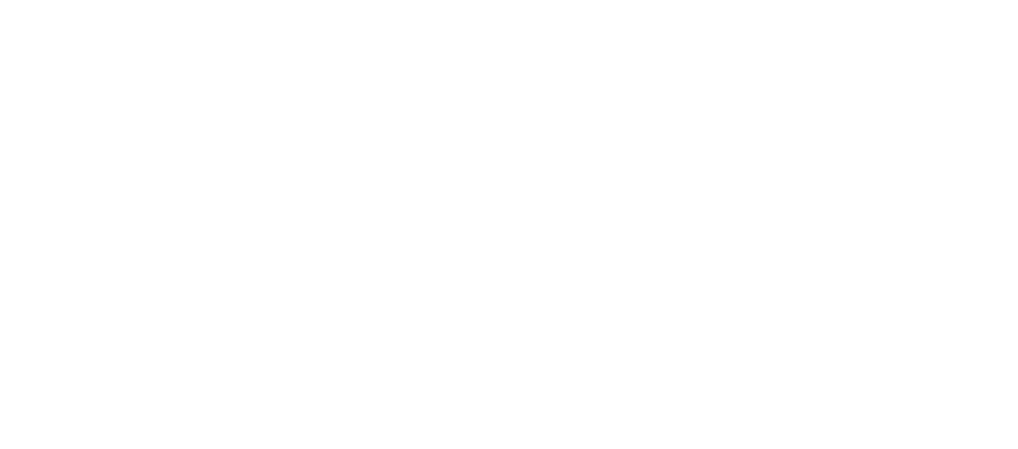

In [14]:
import matplotlib.pyplot as plt

start = 0
end = 1260
df_c = df['close'].reset_index(drop=True)

plt.figure(figsize = (18,8))
plt.axis('off')
plt.plot(df_c[buy_np[start]:sell_np[end]], zorder=0, color='lightblue')
line_x = np.stack((buy_np[start:end], sell_np[start:end]), axis=1)
line_y = np.stack((df_c.iloc[buy_np[start:end]], df_c.iloc[sell_np[start:end]]), axis=1)
for i in range(len(buy_np[start:end])):
    if line_y[i][0] < line_y[i][1]:
        plt.plot(line_x[i], line_y[i], color='r', linewidth=0.7)
    else:
        plt.plot(line_x[i], line_y[i], color='b', linewidth=0.7)
# plt.scatter(buy_np[:100], df_c.iloc[buy_np[:100]], marker='.',color='red', zorder=1)
# plt.scatter(sell_np[:100], df_c.iloc[sell_np[:100]], marker='.',color='blue', zorder=1)
plt.tight_layout()
plt.show()